In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow.keras import Model, layers
import numpy as np
import pandas as pd
import pylab as plt
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
np.random.seed(2000)

In [2]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# Toy example sequence of correlated numbers versus series of unrelated numbers
****

In [3]:
s_length = 10
X = []
c1, c2 = None, None
for i in range(5000):
    a = np.random.random(s_length)
    b = a * 1 + np.random.random(s_length)
    c = np.array(list(zip(a,b)))
    X.append(c)
#     print(np.shape(c1))


for i in range(5000):
    a = np.random.random(s_length)
    b = 2 * np.random.random(s_length)
    c = np.array(list(zip(a,b)))
    X.append(c)

X = np.array(X, dtype=np.float32)


y = np.zeros(10000)
y[5000:] = 1

y = np.array(y, dtype=np.int64)
# y = np.reshape(y, [-1, 1])
# y = tf.keras.utils.to_categorical(y, num_classes=2, dtype='float32')
# y

## split data
***

In [4]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
train_index, test_index = next(sss.split(X, y))
x_train, y_train, x_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5)
val_index, test_index = next(sss.split(x_test, y_test))
x_val, y_val, x_test, y_test = x_test[val_index], y_test[val_index], x_test[test_index], y_test[test_index]

In [5]:
print(np.shape(x_train), np.shape(y_train), np.shape(x_val), np.shape(y_val), np.shape(x_test), np.shape(y_test))

(8000, 10, 2) (8000,) (1000, 10, 2) (1000,) (1000, 10, 2) (1000,)


### Train functions
***

In [6]:
def cross_entropy_loss(logit_pred, label):
    # Convert labels to int 64 for tf cross-entropy function.
    label = tf.cast(label, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit_pred)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

def step_once(model, loss_f, x, y):
    with tf.GradientTape() as g:
        # Forward pass.
        pred = model.call(x, is_training=True)
        # Compute loss.
        loss = loss_f(pred, y)
        
    trainable_variables = model.trainable_variables

    # Compute gradients
    gradients = g.gradient(loss, trainable_variables)
    
    # Update weights
    optimizer.apply_gradients(zip(gradients, trainable_variables))

def optimize(model, optimizer, train_data, x_val, y_val, training_steps, loss_f=cross_entropy_loss, metric_f=accuracy, metric_name="accuracy", log_file="log.csv", model_file="nn.chkp"):
    best_loss = float("inf")
    log = pd.DataFrame(columns=['step', 'metric', 'value'])
    for i, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
        # Run the optimization to update W and b values.
        step_once(model, loss_f, batch_x, batch_y)

        if i % display_step == 0:
            pred = model(batch_x, is_training=True)
            loss = loss_f(pred, batch_y)
            metric = metric_f(pred, batch_y)
            pred_val = model(x_val, is_training=True)
            val_loss = loss_f(pred_val, y_val)
            metric_val = metric_f(pred_val, y_val)
            print("step: %i, loss: %f, %s: %f, Validation loss: %f, %s: %f" % (i, loss.numpy(), metric_name, metric.numpy(), val_loss.numpy(), metric_name, metric_val.numpy()))
            log = log.append({"step":i, "metric":"train_loss", "value": loss.numpy()}, ignore_index=True)
            log = log.append({"step":i, "metric":'train_' + metric_name, "value": metric.numpy()}, ignore_index=True)
            log = log.append({"step":i, "metric":"val_loss", "value": val_loss.numpy()}, ignore_index=True)
            log = log.append({"step":i, "metric":'val_' + metric_name, "value": metric_val.numpy()}, ignore_index=True)
            if(val_loss < best_loss):
                best_loss = val_loss
                model.save_weights(model_file)
    log.to_csv(log_file, index=False)

In [7]:
%%time
class LSTM(Model):
    # Set layers.
    def __init__(self, n_units, num_classes):
        super(LSTM, self).__init__()
        # RNN (LSTM) hidden layer.
        self.lstm_layer = layers.GRU(units=n_units, return_sequences=False)
        self.flatten = layers.Flatten()
        self.out = layers.Dense(num_classes)
        

    # Set forward pass.
    def call(self, x, is_training=False):
        # LSTM layer.
        x = self.lstm_layer(x)
        x = self.flatten(x)
        # Output layer (num_classes).
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x
    

# Data parameters
seed = 1000
num_classes = 2

# Training parameters.
learning_rate = 0.1
training_steps = 1000
batch_size = 256
display_step = 100
prefetch = 1

# Network parameters.
n_unit = 5

log_file='logs/rnn.csv'
model_file = 'models/rnn.chkp'

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(seed).batch(batch_size).prefetch(prefetch)

model = LSTM(n_unit, num_classes)

optimizer = tf.optimizers.SGD(learning_rate)

optimize(model, optimizer, train_data, x_val, y_val, training_steps, loss_f=cross_entropy_loss, metric_f=accuracy, metric_name="accuracy", log_file=log_file, model_file=model_file)

step: 100, loss: 0.690272, accuracy: 0.539062, Validation loss: 0.693354, accuracy: 0.520000
step: 200, loss: 0.689745, accuracy: 0.523438, Validation loss: 0.686692, accuracy: 0.558000
step: 300, loss: 0.681662, accuracy: 0.546875, Validation loss: 0.676825, accuracy: 0.602000
step: 400, loss: 0.662638, accuracy: 0.648438, Validation loss: 0.655984, accuracy: 0.708000
step: 500, loss: 0.599338, accuracy: 0.808594, Validation loss: 0.601357, accuracy: 0.787000
step: 600, loss: 0.472569, accuracy: 0.875000, Validation loss: 0.478327, accuracy: 0.854000
step: 700, loss: 0.340698, accuracy: 0.878906, Validation loss: 0.315641, accuracy: 0.907000
step: 800, loss: 0.228162, accuracy: 0.917969, Validation loss: 0.221708, accuracy: 0.926000
step: 900, loss: 0.206736, accuracy: 0.917969, Validation loss: 0.179199, accuracy: 0.936000
step: 1000, loss: 0.171863, accuracy: 0.945312, Validation loss: 0.153599, accuracy: 0.943000
CPU times: user 6.3 s, sys: 433 ms, total: 6.73 s
Wall time: 6.43 s


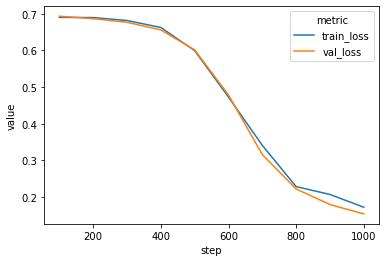

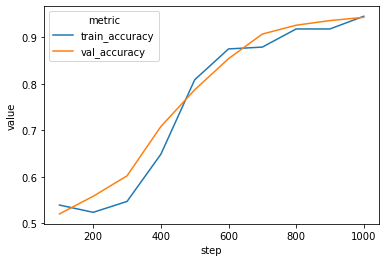

In [8]:
training_trajectory = pd.read_csv(log_file)
training_trajectory.head()
for x in set(map(lambda x: x.split('_')[1], training_trajectory['metric'].unique())):
    data = training_trajectory[training_trajectory['metric'].str.contains(x)]
    sns.lineplot(data=data, x='step', y='value', hue='metric')
    plt.show()


In [9]:
model = model = LSTM(n_unit, num_classes)
model.load_weights(model_file)
pred = model(x_test, is_training=False)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.945000


In [10]:
a = np.random.choice(len(y_test), 3)

predictions = model(x_test)

# Display image and model prediction.
for i in a:
    print(x_test[i])
    print("Model prediction: %i, Correct: %i" % (np.argmax(predictions.numpy()[i]), y_test[i]))

[[0.6439171  1.6401826 ]
 [0.9410564  1.5794568 ]
 [0.42088228 0.42255604]
 [0.3971467  0.70582205]
 [0.57400775 1.2909019 ]
 [0.49976265 1.4122459 ]
 [0.8897257  1.1088543 ]
 [0.897558   1.3897247 ]
 [0.5411644  1.3653569 ]
 [0.05077849 0.37447566]]
Model prediction: 0, Correct: 0
[[0.26024488 1.9699527 ]
 [0.8166467  0.4861699 ]
 [0.33741784 1.7424264 ]
 [0.6163024  0.9805419 ]
 [0.36371362 0.576483  ]
 [0.7372654  0.14974786]
 [0.69372964 1.365963  ]
 [0.41965184 1.5868348 ]
 [0.35457125 0.31000915]
 [0.5634515  1.8659533 ]]
Model prediction: 1, Correct: 1
[[0.10061163 1.2836726 ]
 [0.27281955 1.5881985 ]
 [0.8806432  0.50606865]
 [0.87933207 0.8417861 ]
 [0.47224852 0.11129989]
 [0.74319816 0.15618356]
 [0.5960071  1.5171257 ]
 [0.29282358 0.6654849 ]
 [0.47143516 1.7485172 ]
 [0.37033102 1.8775194 ]]
Model prediction: 1, Correct: 1


# text generation
*****

In [11]:
from keras.utils import np_utils

In [12]:
text = open("alice.txt").read().lower()
text = text.replace('\n', ' ').replace('(', ' ').replace(')', ' ').replace('[', ' ').replace(']', ' ').replace('ù', ' ').replace('—', ' ')

In [13]:
characters = sorted(list(set(text)))

n_to_char = {n:char for n, char in enumerate(characters)}
char_to_n = {char:n for n, char in enumerate(characters)}
factor = len(characters)
print(factor)

39


In [14]:
n_to_char

{0: ' ',
 1: '!',
 2: ',',
 3: '-',
 4: '.',
 5: ':',
 6: ';',
 7: '?',
 8: '_',
 9: 'a',
 10: 'b',
 11: 'c',
 12: 'd',
 13: 'e',
 14: 'f',
 15: 'g',
 16: 'h',
 17: 'i',
 18: 'j',
 19: 'k',
 20: 'l',
 21: 'm',
 22: 'n',
 23: 'o',
 24: 'p',
 25: 'q',
 26: 'r',
 27: 's',
 28: 't',
 29: 'u',
 30: 'v',
 31: 'w',
 32: 'x',
 33: 'y',
 34: 'z',
 35: '‘',
 36: '’',
 37: '“',
 38: '”'}

In [15]:
X = []   # extracted sequences
Y = []   # the target: follow up character for each sequence in X
length = len(text)
seq_length = 50

for i in range(0, len(text) - seq_length, 1):
    sequence = text[i:i + seq_length]
    label = text[i + seq_length]
    X.append([char_to_n[char] for char in sequence])
    Y.append(char_to_n[label])

In [16]:
np.shape(X), np.shape(Y)

((143072, 50), (143072,))

In [17]:
X = np.reshape(X, (len(X), seq_length, 1))
X = X / float(len(characters))
# Y = np_utils.to_categorical(Y)
np.shape(X), np.shape(Y)


((143072, 50, 1), (143072,))

In [18]:
X = np.array(X, dtype=np.float32)

In [19]:
np.shape(X)

(143072, 50, 1)

In [20]:
    
%%time
def optimize(model, optimizer, train_data, training_steps, loss_f=cross_entropy_loss, metric_f=accuracy, metric_name="accuracy", log_file="log.csv", model_file=''):
    log = pd.DataFrame(columns=['step', 'metric', 'value'])
    best_loss = float("inf")
    for i, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
        # Run the optimization to update W and b values.
        step_once(model, loss_f, batch_x, batch_y)

        if i % display_step == 0:
            pred = model(batch_x, is_training=True)
            loss = loss_f(pred, batch_y)
            metric = metric_f(pred, batch_y)
           
            print("step: %i, loss: %f, %s: %f" % (i, loss.numpy(), metric_name, metric.numpy()))
            log = log.append({"step":i, "metric":"train_loss", "value": loss.numpy()}, ignore_index=True)
            log = log.append({"step":i, "metric":'train_' + metric_name, "value": metric.numpy()}, ignore_index=True)
            if(loss < best_loss):
                best_loss = loss
                model.save_weights(model_file)
    log.to_csv(log_file, index=False)
    

class LSTM2(Model):
    # Set layers.
    def __init__(self, n_units, num_classes):
        super(LSTM2, self).__init__()
        # RNN (LSTM) hidden layer.
        self.lstm_layer1 = layers.LSTM(units=n_units, kernel_initializer="glorot_uniform", dropout=0, activation='tanh', return_sequences=True)
        self.lstm_layer2 = layers.LSTM(units=n_units, kernel_initializer="glorot_uniform", dropout=0, activation='tanh', return_sequences=False)
        self.lstm_layer3 = layers.LSTM(units=n_units, kernel_initializer="glorot_uniform", dropout=0, activation='tanh')
#         self.dropout = layers.Dropout(0.2)
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x, is_training=False):
        # LSTM layer.
        x = self.lstm_layer1(x)
#         x = np.reshape()
        x = self.lstm_layer2(x)
#         x = self.lstm_layer3(x)
        # Output layer (num_classes).
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x
    

# Data parameters
seed = 1000
num_classes = 46

# Training parameters.
learning_rate = 0.01
training_steps = 1000000
batch_size = 512
display_step = 2000
prefetch = 1

# Network parameters.
n_unit = 128
log_file='logs/text_pred.csv'
model_file='models/text_pred.chkp'

train_data = tf.data.Dataset.from_tensor_slices((X, Y))
train_data = train_data.repeat().shuffle(seed).batch(batch_size).prefetch(prefetch)

model = LSTM2(n_unit, num_classes)

optimizer = tf.optimizers.SGD(learning_rate)

optimize(model, optimize, train_data, training_steps, loss_f=cross_entropy_loss, metric_f=accuracy, metric_name="accuracy", log_file=log_file, model_file=model_file)

KeyboardInterrupt: 

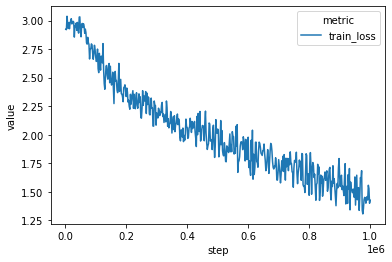

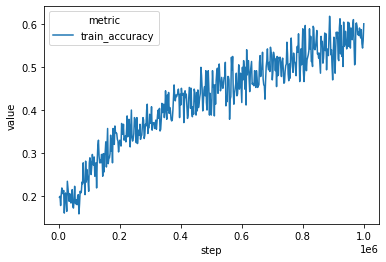

In [21]:
training_trajectory = pd.read_csv(log_file)
training_trajectory.head()
for x in set(map(lambda x: x.split('_')[1], training_trajectory['metric'].unique())):
    data = training_trajectory[training_trajectory['metric'].str.contains(x)]
    sns.lineplot(data=data, x='step', y='value', hue='metric')
    plt.show()


In [22]:
model = LSTM2(n_unit, num_classes)
model.load_weights(model_file)
l = []
start  = np.random.choice(len(X))
a = X[start]
# temp = np.array(np.around(X[start]), dtype=np.int64)
temp = list(map(lambda x: n_to_char[int(np.around(x[0]*factor))], a))
# print(temp)
# for a in temp:
# #     print(n_to_char[a[0]])
#     l.append(n_to_char[a[0]])
#     print(l)
l.extend(temp)
l.append('|')
# print(l)
# print(X[start] * 46, temp)
start = np.reshape(X[start], [1, 50, 1])
for i in range(200):
    n = np.argmax(model(start))
    l.append(n_to_char[n])
    a[0:-1] = a[1:]
    
    a[-1] = n * 1.0  / factor
#     print
    
''.join(l)

'ke what i get’ is the same thing as ‘i get what i |would the dorrte, i meant and she would her heard the mookers on a crowt of the goowo the cour, and the mors rane the dormouse ho the king as the cours of the was  who was garted to the semes of the  '